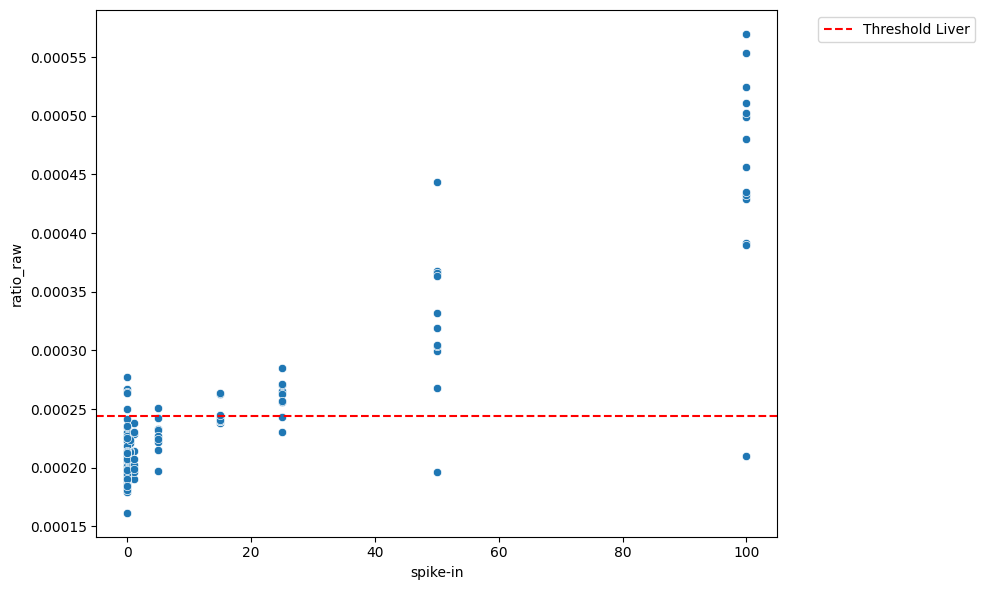

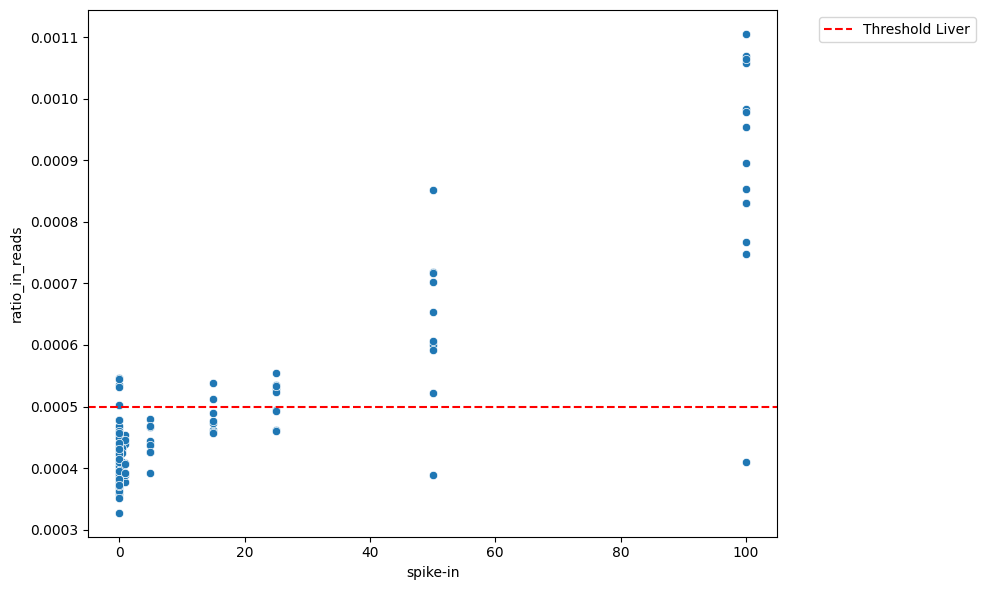

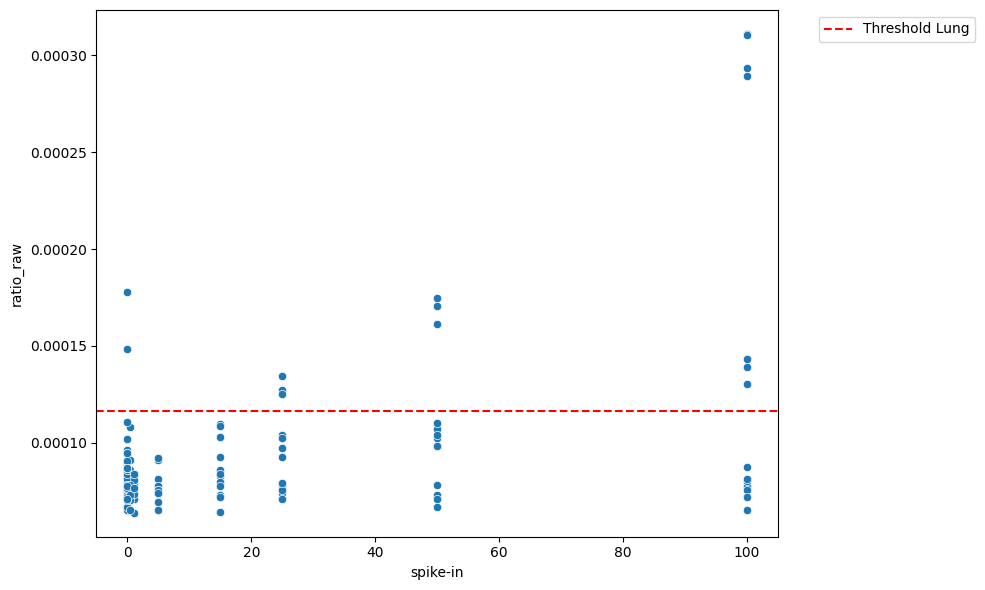

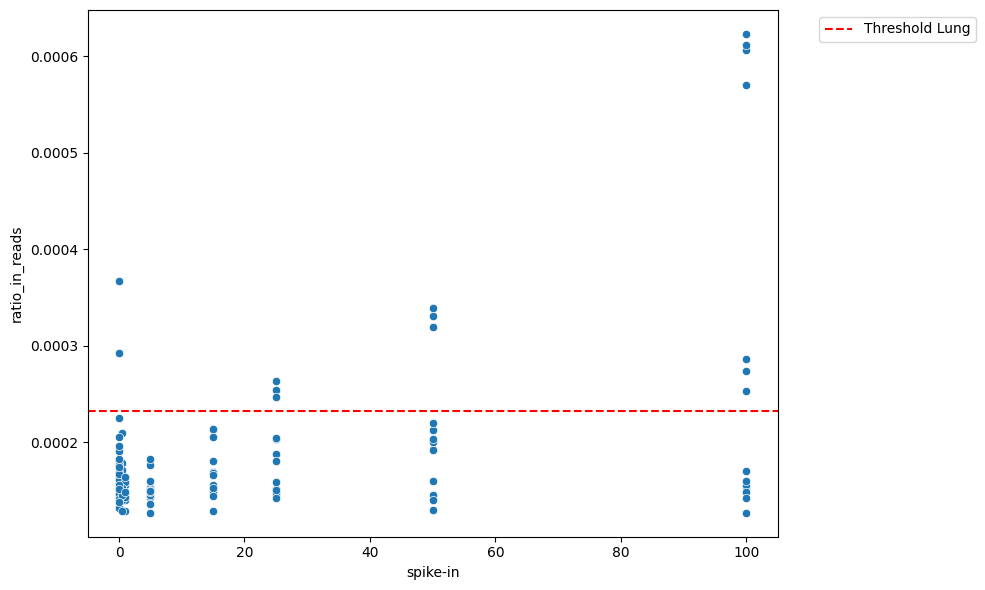

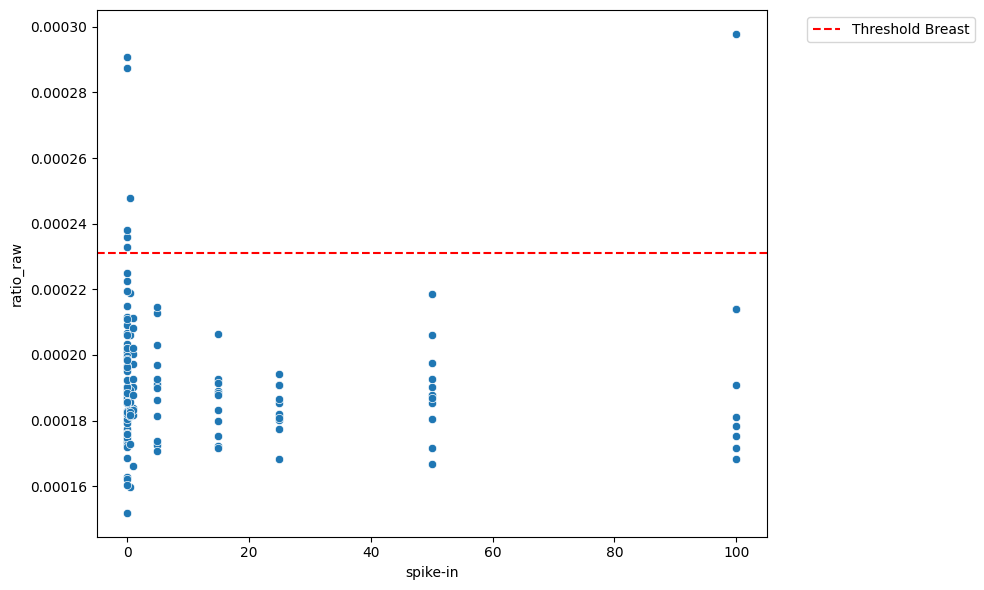

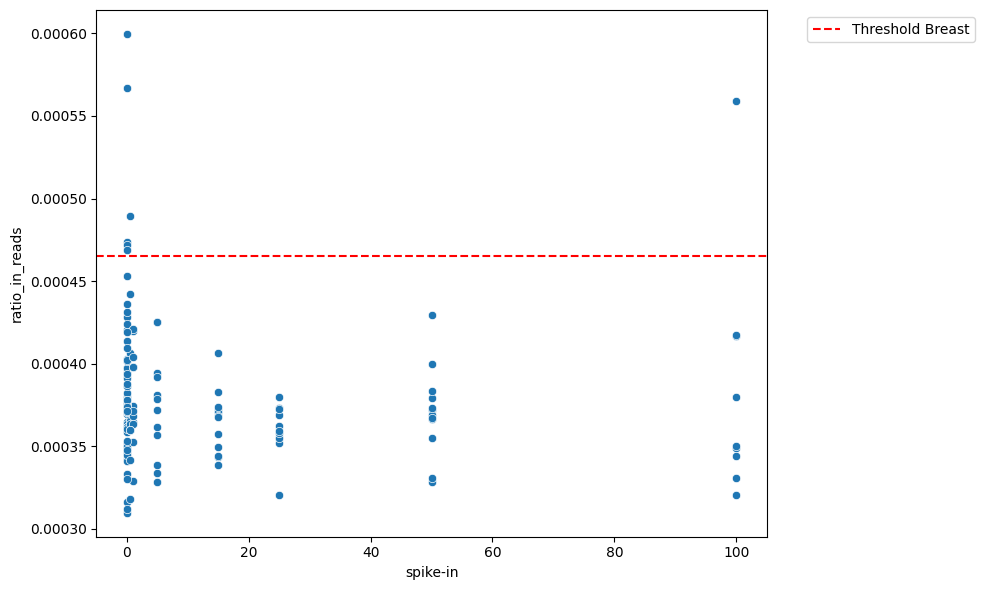

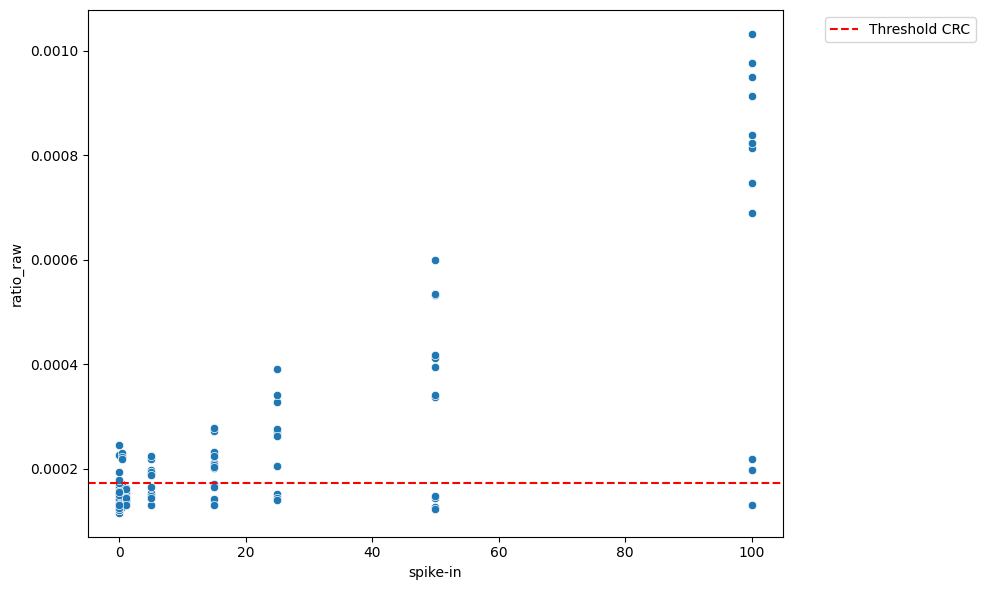

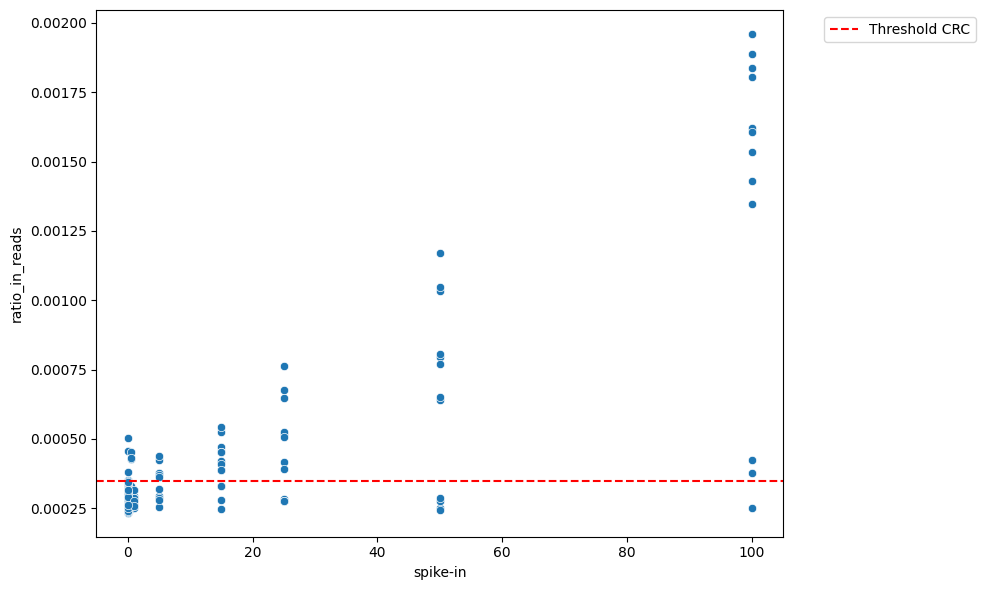

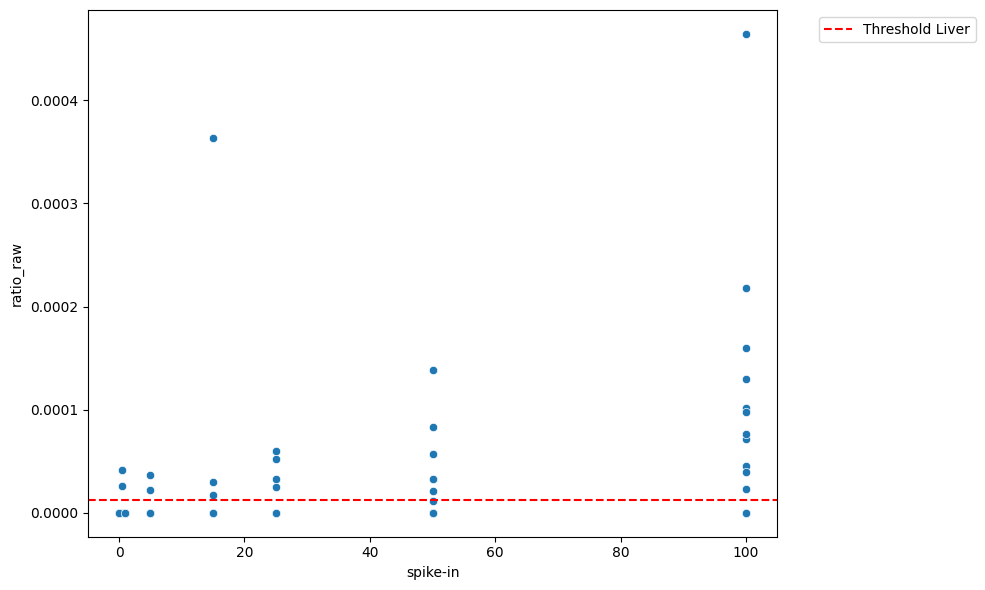

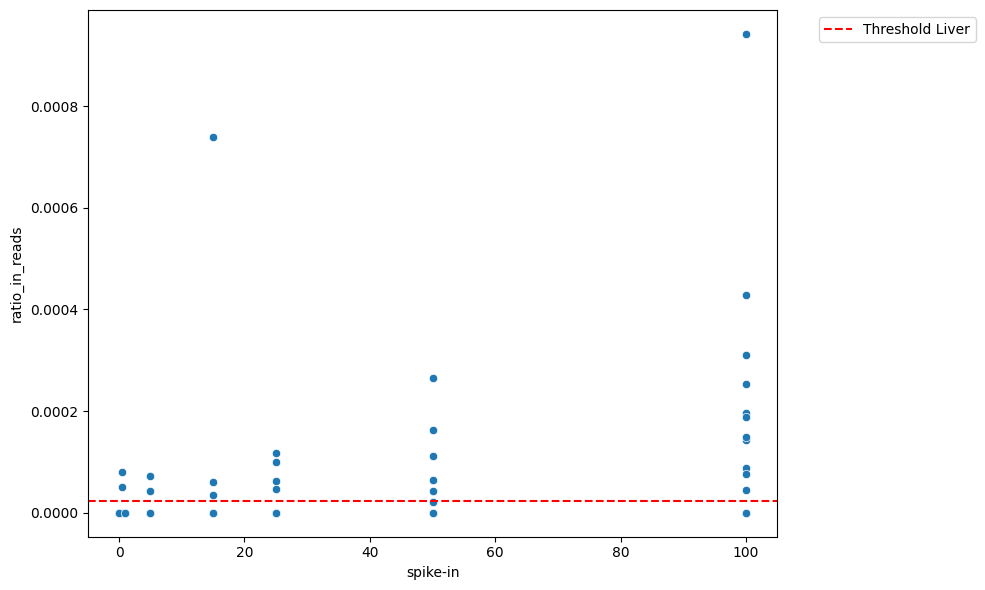

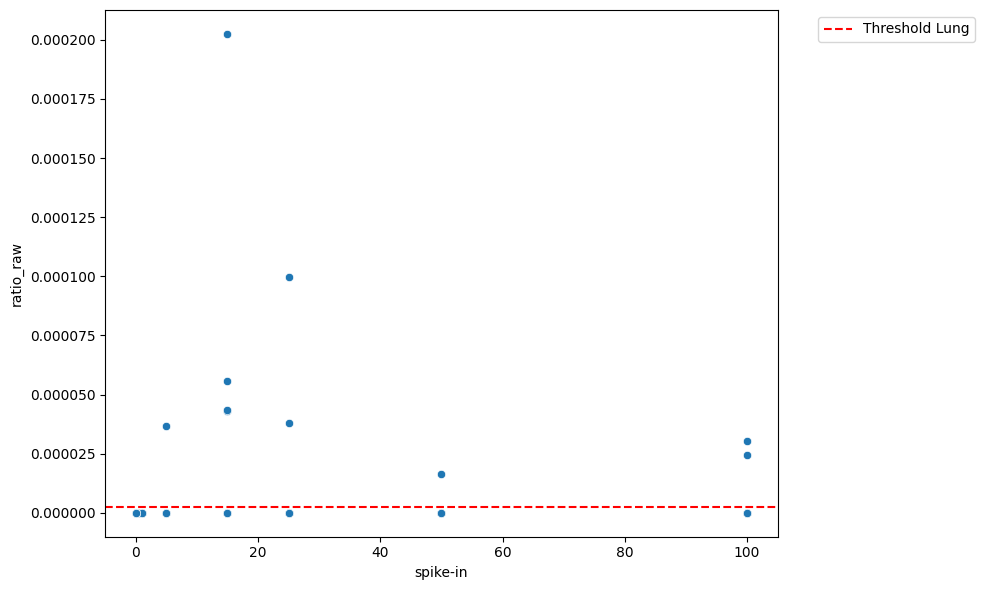

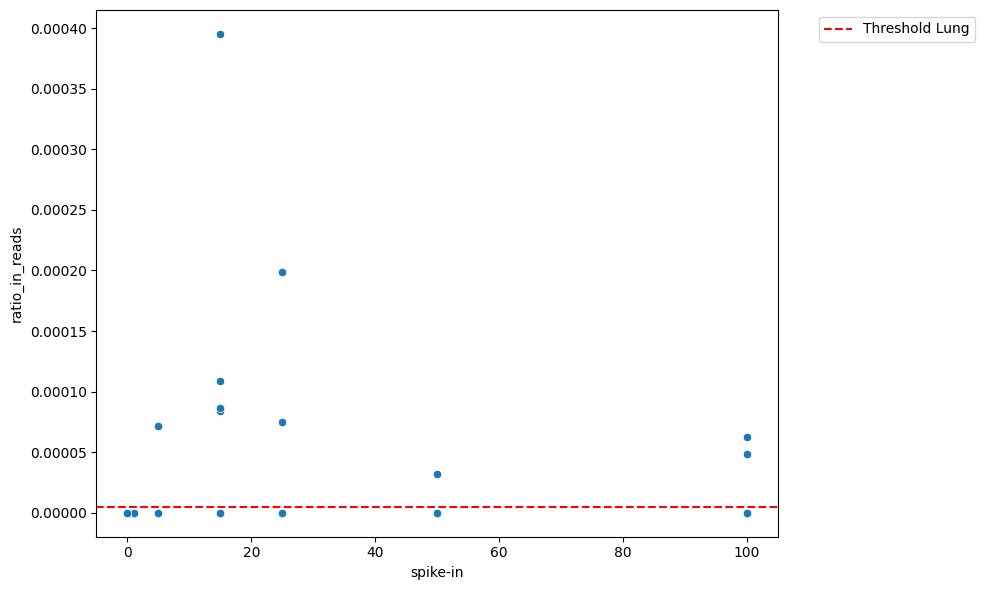

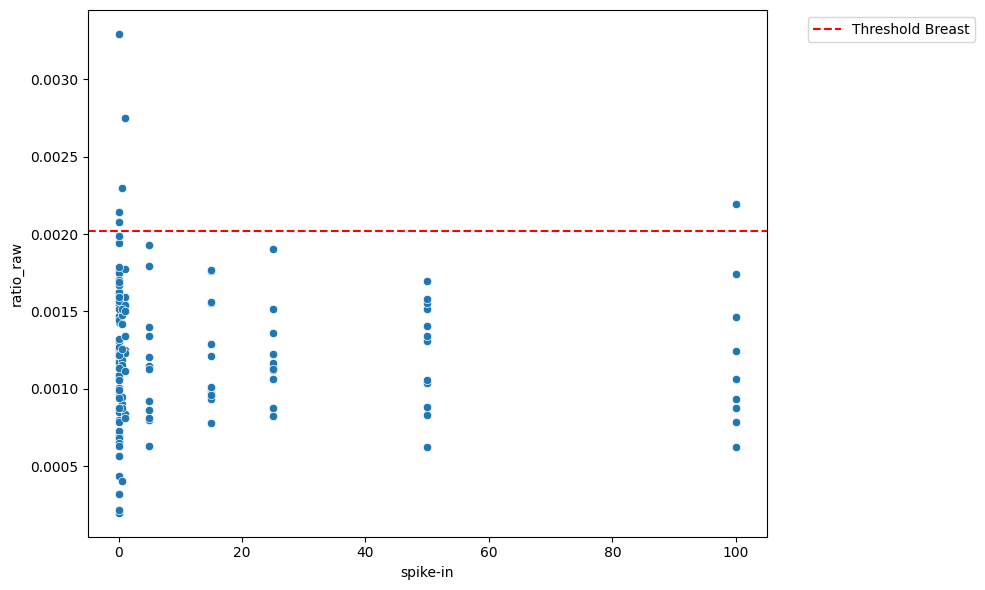

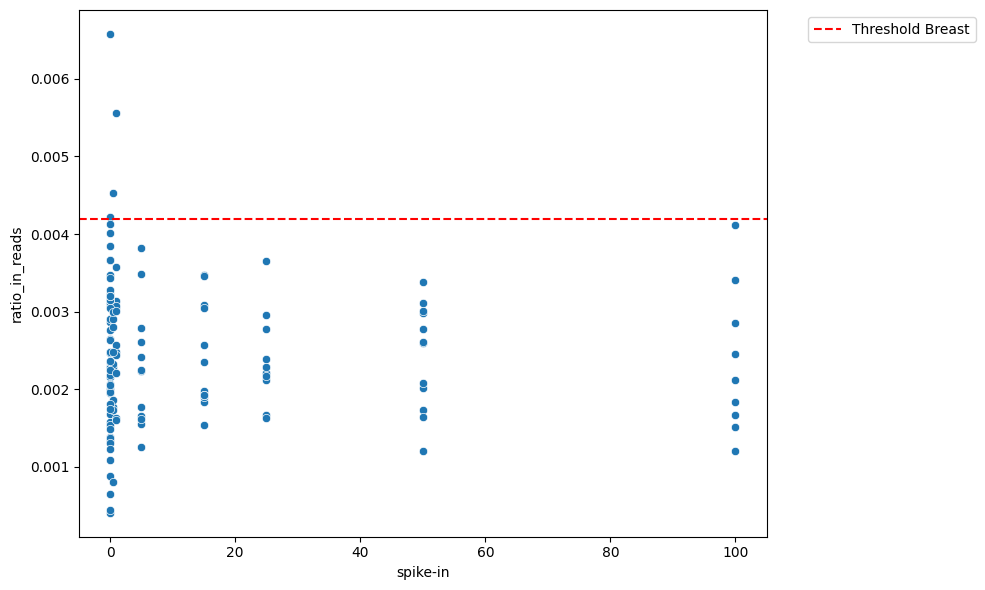

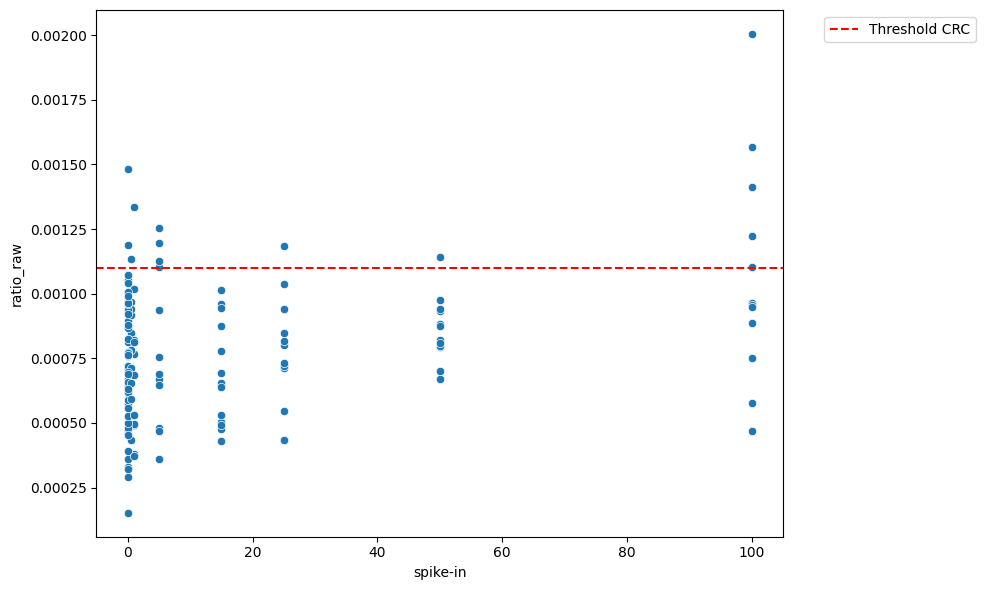

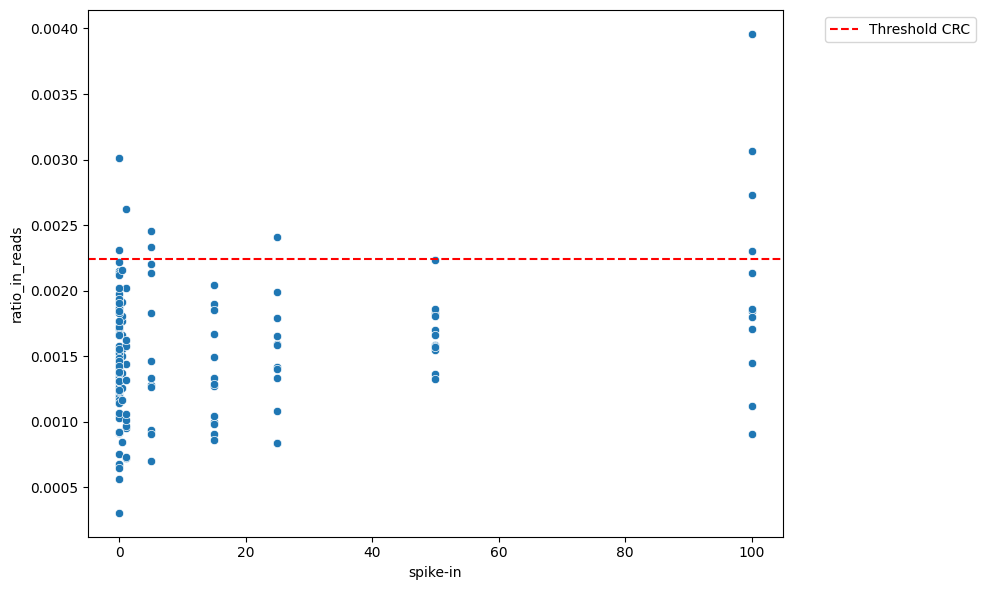

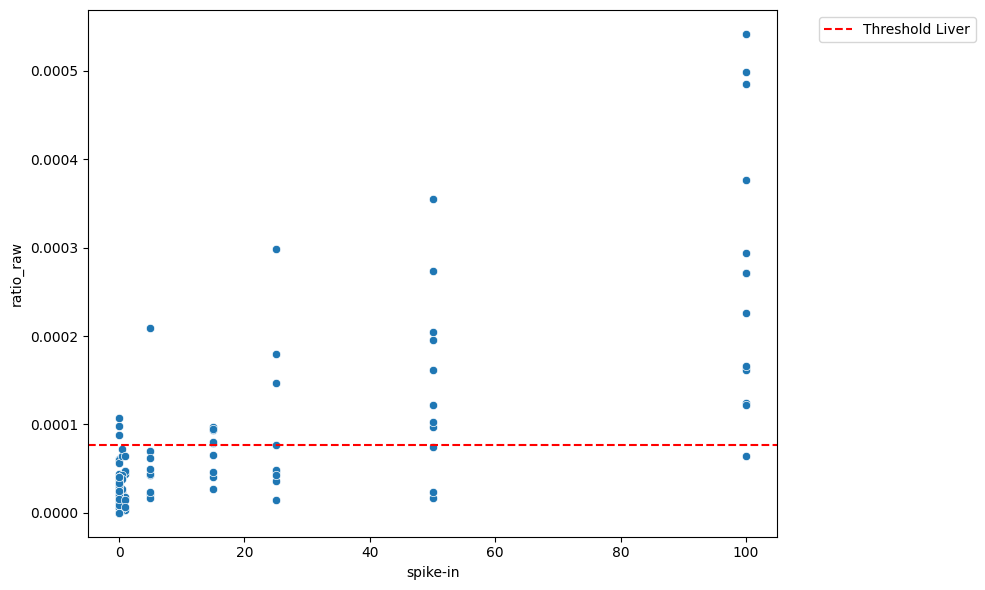

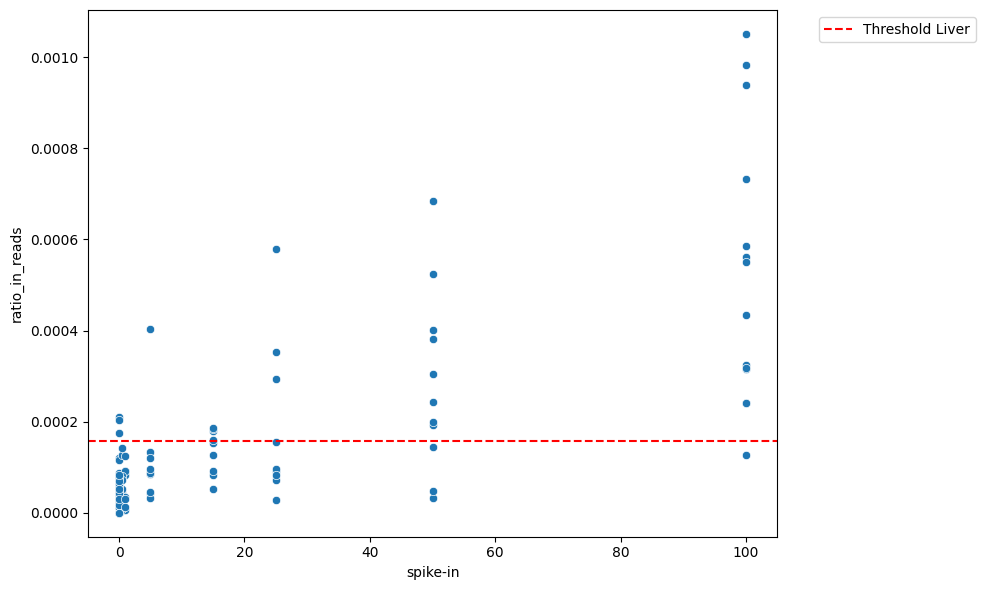

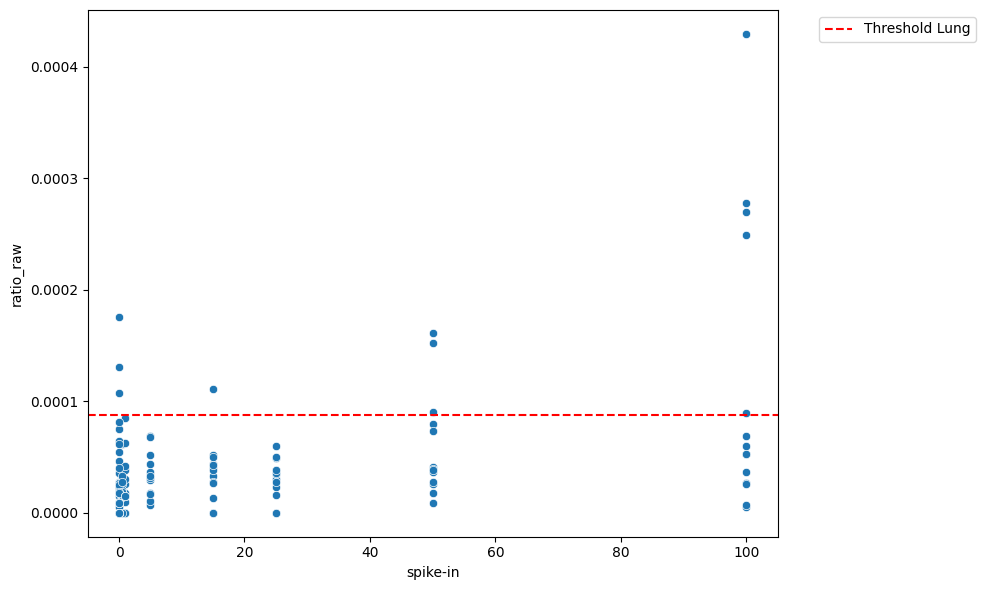

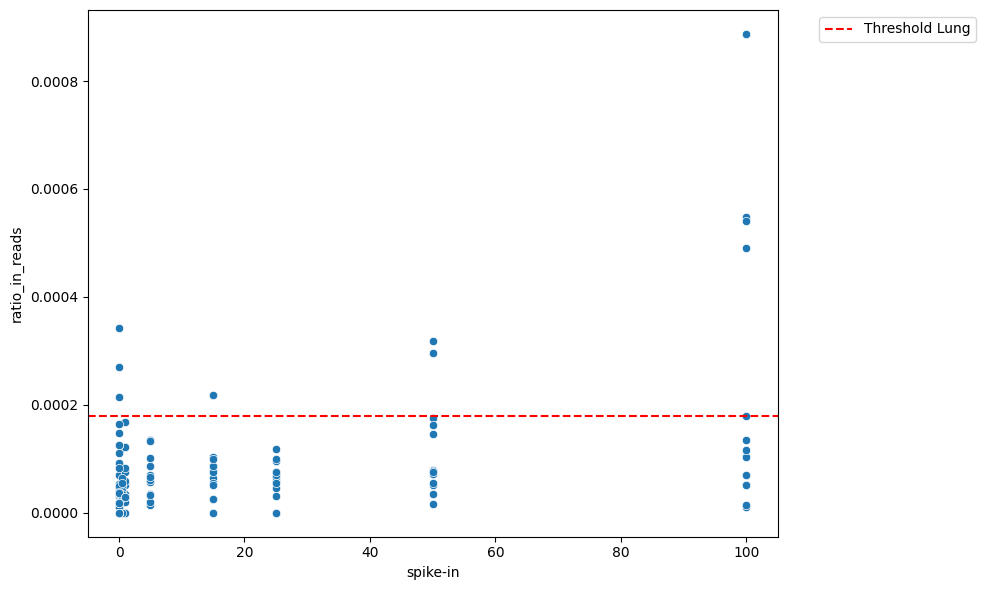

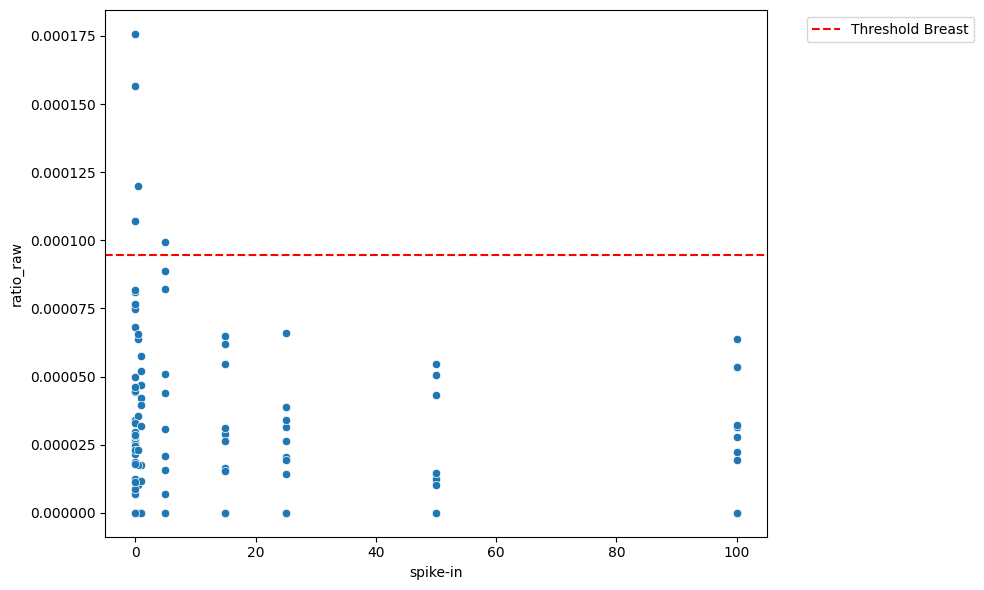

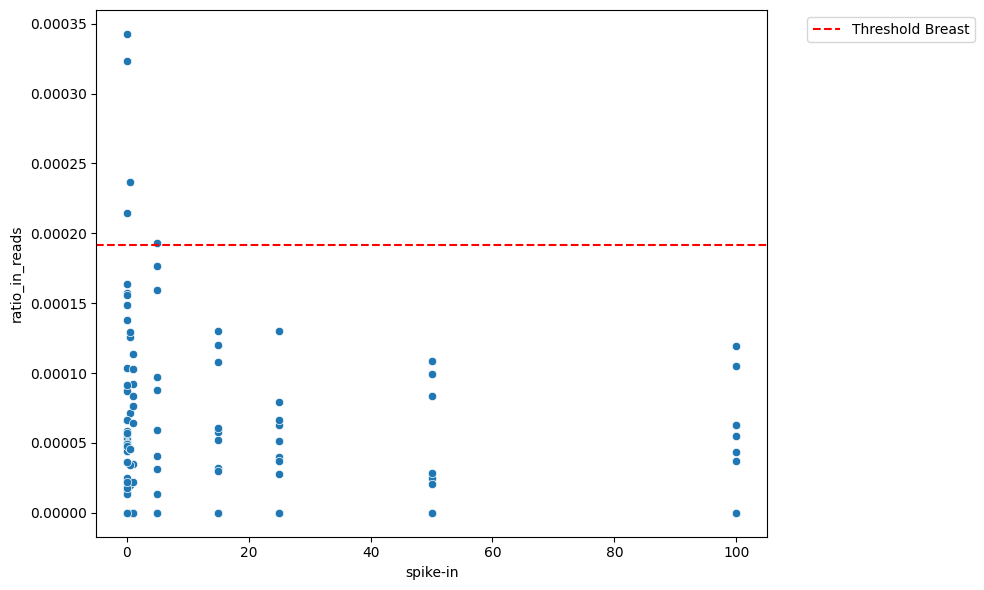

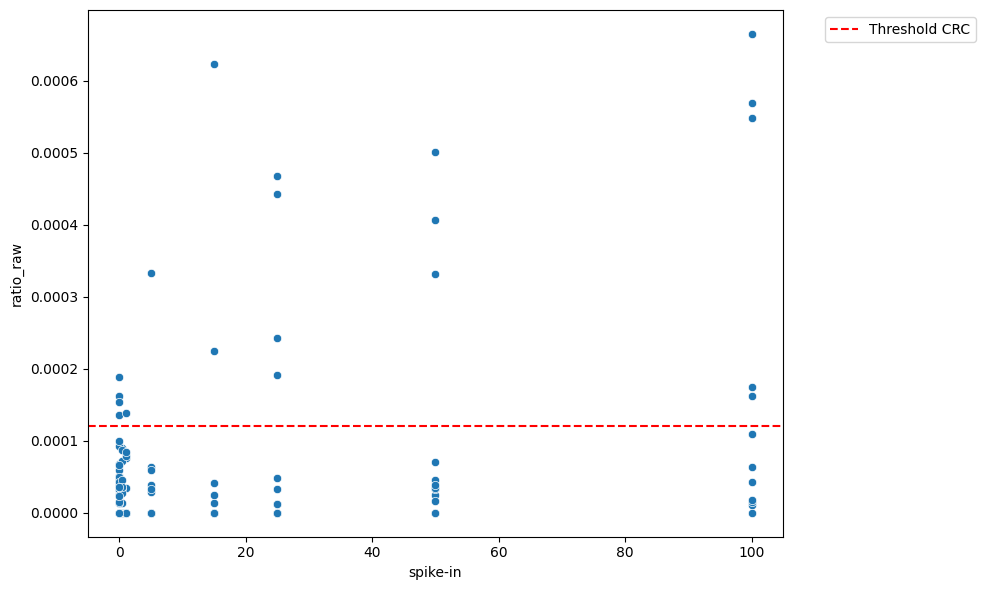

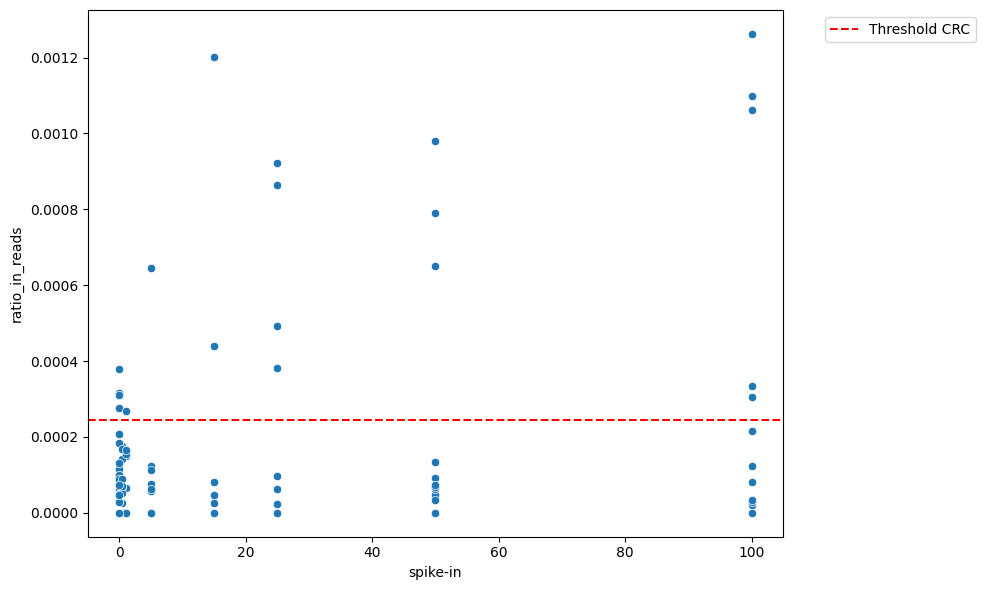

In [1]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import roc_curve, auc
from scipy.stats import pearsonr

warnings.filterwarnings('ignore')

data_version = "TMD_cov"
output_version = "20240910"

outdir = "/media/hieunguyen/HNSD_mini/outdir"
PROJECT = "TMD450_TCGA_data_analysis"
thres_hypo = 0.3
thres_hyper = 0.6

convert_ratio = {
    '0001': 0.001, 
    '001': 0.01, 
    '0005': 0.005, 
    '005': 0.05, 
    '01': 0.1
}
for mode in ["all", "hypo_only", "hyper_only"]:
    all_cancer_classes = ["Liver", "Lung", "Breast", "CRC"]
    thresdf = pd.read_csv(f"thresdf.{mode}.csv")

    for input_cancer_class in all_cancer_classes:
        path_to_main_output = os.path.join(outdir, PROJECT, output_version)

        if mode == "all":
            path_to_11_output = os.path.join(outdir, PROJECT, output_version, "11_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
            path_to_12_output = os.path.join(outdir, PROJECT, output_version, "12_output", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
        elif mode == "hypo_only":
            path_to_11_output = os.path.join(outdir, PROJECT, output_version, "11_output_all_hypo", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
            path_to_12_output = os.path.join(outdir, PROJECT, output_version, "12_output_all_hypo", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
        elif mode == "hyper_only":
            path_to_11_output = os.path.join(outdir, PROJECT, output_version, "11_output_all_hyper", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))
            path_to_12_output = os.path.join(outdir, PROJECT, output_version, "12_output_all_hyper", input_cancer_class, "thres_hypo_{}_hyper_{}".format(thres_hypo, thres_hyper))

        os.system(f"mkdir -p {path_to_12_output}")

        all_files = [item for item in pathlib.Path(path_to_11_output).glob("*.candi_reads.csv")]
        countdf = pd.read_csv(os.path.join(path_to_11_output, "all_count.csv"), index_col = [0])

        all_samples = []
        all_mean_candi_reads = []
        for file in all_files:
            tmpdf = pd.read_csv(file)
            mean_candi_reads = tmpdf.candi_reads.mean()
            all_samples.append(file.name.split(".")[0])
            all_mean_candi_reads.append(mean_candi_reads)

        candidf = pd.DataFrame({"SampleID": all_samples, "num_candi_reads": all_mean_candi_reads})
        candidf = candidf.merge(countdf, right_on = "SampleID", left_on = "SampleID")
        candidf["ratio_raw"] = candidf["num_candi_reads"] / candidf["raw_count"]
        candidf["ratio_in_reads"] = candidf["num_candi_reads"] / candidf["in_read_count"]

        lod_metadata = pd.read_csv("analytical_LOD_TF 1.csv")
        candidf = candidf.fillna(0)
        candidf = candidf.merge(lod_metadata, right_on = "Sample", left_on = "SampleID")
        candidf["LABEL"] = candidf["LABEL"].apply(lambda x: "CRC" if x == "Colorectal cancer" else x.split(" ")[0])

        convert_ratio = {
            '5': 5, 
            'HC': 0, 
            '100': 100, 
            '50': 50, 
            '0.5': 0.5, 
            '15': 15, 
            '1': 1, 
            '25': 25
        }
        candidf = candidf[candidf["LABEL"] == input_cancer_class]
        candidf["spike-in"] = candidf["spike-in"].apply(lambda x: convert_ratio[str(x)])
        candidf.to_excel(os.path.join(path_to_12_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)), index = False)

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data = candidf, x = "spike-in", y = "ratio_raw")
        plt.axhline(y=thresdf[thresdf["cancer_class"] == input_cancer_class]["ratio_raw"].values[0], 
                            color='r', linestyle='--', label=f'Threshold {input_cancer_class}')
                
        figname1 = f"LOD_samples_{input_cancer_class}_raw_ratio.svg"
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_12_output, figname1), format='svg')
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data = candidf, x = "spike-in", y = "ratio_in_reads")
        plt.axhline(y=thresdf[thresdf["cancer_class"] == input_cancer_class]["ratio_in_reads"].values[0], 
                    color='r', linestyle='--', label=f'Threshold {input_cancer_class}')
 
        figname2 = f"LOD_samples_{input_cancer_class}_raw_ratio.svg"
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_12_output, figname2), format='svg')
        plt.show()
